In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
path="/content/drive/My Drive/CogSci3ATS"
os.chdir(path)
os.listdir(path)

['PreSumm',
 'data',
 'ATS.ipynb',
 'img',
 'glove-text-summarization-seq2seq.ipynb',
 'anova.ipynb',
 'ATS-seq2seq2.ipynb']

In [3]:
!pip install tensorflow-gpu==1.15
# import keras==2.2.4
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget
import nltk


     |████████████████████████████████| 411.5 MB 6.5 kB/s 
     |████████████████████████████████| 503 kB 45.9 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 3.8 MB 61.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7f6eb82dd9aaf2f65ea6adfa9fc616060a1b7d93a3f646b9934a1a8f93959a68
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [4]:
!ls data

dataloader.py		     predictions-models.csv
EnglishMaterial.xlsx	     Reviews.csv
evaluation_metric.py	     Reviews.csv.zip
fast_result_unknow0.csv      text_and_annorations.csv
Fixation_sequence.csv	     train.article.txt
geco_dict.pkl		     training_data.csv
geco_result_average.csv      train.title.txt
geco_result_unknow0.csv      tutorial.ipynb
geco_result_unknow_big.csv   valid.article.filter.txt
geco_result_unknow.csv	     valid.title.filter.txt
geco_small.csv		     wiki.en.vec.short50K
geco_small_filter.csv	     zuco_dict.pkl
geco_whole.csv		     zuco_result_unknow_big.csv
gold_data.csv		     zuco_result_unknow.csv
model.py		     zugeco_result_unknow0.csv
MonolingualReadingData.xlsx


In [ ]:
#!unzip '/content/drive/My Drive/CogSci3ATS/data/Reviews.csv.zip'

Archive:  /content/drive/My Drive/CogSci3ATS/data/Reviews.csv.zip
  inflating: Reviews.csv             


In [5]:
data=pd.read_csv("data/Reviews.csv")
data[['Text','Summary']]

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy
...,...,...
568449,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..,Will not do without
568450,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left,...",disappointed
568451,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y...",Perfect for our maltipoo
568452,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...,Favorite Training and reward treat


In [6]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [ ]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t).lower())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(t.lower())

In [ ]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [10]:

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t).lower())

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
cleaned_summary[2]

'delight says it all '

In [ ]:
data['Summary'][2]

'"Delight" says it all'

In [11]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

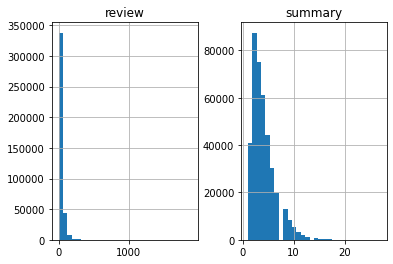

In [ ]:

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))
length_df = pd.DataFrame({'review':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.savefig('img/dataset1.png')
plt.show()

In [18]:
max_len_text=80 
max_len_summary=10
#from sklearn.model_selection import train_test_split
#x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=42,shuffle=True) 


In [12]:
len(data)

393222

In [16]:
len(data['cleaned_text'][275255:314577])

39322

In [17]:
x_tr,x_val,x_test,y_tr,y_val,y_test = data['cleaned_text'][0:275255],data['cleaned_text'][275255:314577],data['cleaned_text'][314577:],data['cleaned_summary'][0:275255],data['cleaned_summary'][275255:314577],data['cleaned_summary'][314577:]


In [42]:
len(x_test)

78645

In [19]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)
x_test   =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')
x_test   =   pad_sequences(x_test, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [20]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 
y_test   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')
y_test   =   pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

# Rouge evaluation

In [21]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()
def rouge_score(reference,hypothesis):
    scores = rouge.get_scores(hypothesis,reference)
    return scores[0]["rouge-1"]["f"],scores[0]["rouge-2"]["f"],scores[0]["rouge-l"]["f"]


# Normalization and Standardization

In [22]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 
 
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma



# Model

## attention

In [23]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Without Cognitive Data

## load glove embedding

In [24]:
# GLOVE_DIR = path for glove.6B.100d.txt
def glove_100d_dictionary(GLOVE_DIR):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, 'data/wiki.en.vec.short50K'))
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index

### embedding matrix without cognitive data

In [25]:
embeddings_index = {}
f = open('data/wiki.en.vec.short50K')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 49999 word vectors.


In [26]:
word_index = x_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
len(embedding_matrix)

51650

### train

In [ ]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, 300, weights=[embedding_matrix],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, 300, weights=[embedding_matrix],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 300)      34380600    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.8515 - val_loss: 2.4772
Epoch 2/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 2.3865 - val_loss: 2.2663
Epoch 3/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 2.2160 - val_loss: 2.1760
Epoch 4/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 2.1136 - val_loss: 2.1249
Epoch 5/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 2.0375 - val_loss: 2.0912
Epoch 6/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 1.9727 - val_loss: 2.0736
Epoch 7/50
353899/353899 [==============================] - 505s 1ms/sample - loss: 1.9157 - val_loss: 2.0741
Epoch 00007: early stopping


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 515s 1ms/sample - loss: 2.8603 - val_loss: 2.5027
Epoch 2/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.3897 - val_loss: 2.2651
Epoch 3/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.2149 - val_loss: 2.1756
Epoch 4/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.1113 - val_loss: 2.1260
Epoch 5/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.0334 - val_loss: 2.0917
Epoch 6/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 1.9690 - val_loss: 2.0741
Epoch 7/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 1.9115 - val_loss: 2.0715
Epoch 8/50
353899/353899 [==============================] - 510s 1ms/sample - loss: 1.8592 - val_loss: 2.0651
Epoch 9/50
353899/353899 [==============================] - 510s 1ms/

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:


f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)
print(sum(f1_list)/len(f1_list))
print(sum(f2_list)/len(f2_list))
print(sum(fl_list)/len(fl_list))


100%|██████████| 39323/39323 [40:23<00:00, 16.22it/s]

0.13315928188251663
0.029853251521475624
0.13151218563142586


In [ ]:
geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/fast_result_unknow0.csv')

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 3.0586 - val_loss: 2.7630
Epoch 2/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.7868 - val_loss: 2.6190
Epoch 3/50
79516/79516 [==============================] - 101s 1ms/sample - loss: 2.6295 - val_loss: 2.4908
Epoch 4/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.5026 - val_loss: 2.3944
Epoch 5/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.3873 - val_loss: 2.3349
Epoch 6/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.2868 - val_loss: 2.3052
Epoch 7/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.1972 - val_loss: 2.2625
Epoch 8/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.1150 - val_loss: 2.2437
Epoch 9/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.0362 - va

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 365s 5ms/sample - loss: 3.3432 - val_loss: 2.8927
Epoch 2/50
79516/79516 [==============================] - 363s 5ms/sample - loss: 2.9037 - val_loss: 2.7251
Epoch 3/50
79516/79516 [==============================] - 364s 5ms/sample - loss: 2.7006 - val_loss: 2.5617
Epoch 4/50
79516/79516 [==============================] - 365s 5ms/sample - loss: 2.5389 - val_loss: 2.4629
Epoch 5/50
79516/79516 [==============================] - 365s 5ms/sample - loss: 2.4137 - val_loss: 2.3577
Epoch 6/50
79516/79516 [==============================] - 365s 5ms/sample - loss: 2.3101 - val_loss: 2.3461
Epoch 7/50
79516/79516 [==============================] - 364s 5ms/sample - loss: 2.2216 - val_loss: 2.2997
Epoch 8/50
79516/79516 [==============================] - 364s 5ms/sample - loss: 2.1395 - val_loss: 

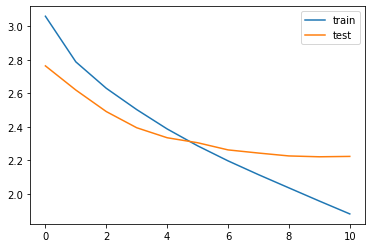

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


In [ ]:

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm

## calculate rouge score

In [ ]:
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


100%|██████████| 8836/8836 [10:20<00:00, 14.24it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

# With Cognitive Data

## pre-process cognitive data

In [ ]:
!ls data/

dataloader.py		Reviews.csv		  tutorial.ipynb
evaluation_metric.py	Reviews.csv.zip		  valid.article.filter.txt
Fixation_sequence.csv	text_and_annorations.csv  valid.title.filter.txt
gold_data.csv		train.article.txt	  wiki.en.vec.short50K
model.py		training_data.csv
predictions-models.csv	train.title.txt


### ZUCO

In [ ]:
# Load ZuCo corpus (train, test and gold data files)
training_data = pd.read_csv("data/training_data.csv")
gold_data = pd.read_csv("data/gold_data.csv")

#print(len(training_data['sentence_id'].unique()), "training sentences including", len(training_data), "words.")
#print(len(gold_data['sentence_id'].unique()), "test sentences including", len(gold_data), "words.")

In [ ]:
for i in range(len(training_data)):
  training_data['word'][i] = training_data['word'][i].replace('.<EOS>','').lower()
  training_data['word'][i] = training_data['word'][i].replace('<SOS>','').lower()
for i in range(len(gold_data)):
  gold_data['word'][i] = gold_data['word'][i].replace('.<EOS>','').lower()
  gold_data['word'][i] = gold_data['word'][i].replace('.<SOS>','').lower()


In [ ]:
training_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778


In [ ]:
gold_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,800,0,it's,5.747126,1.384927,1.384927,1.783566,33.333333
1,800,1,the,14.942529,2.859205,4.398777,4.773360,66.666667
2,800,2,funniest,33.333333,3.312829,8.673838,10.175607,100.000000
3,800,3,american,36.781609,3.426235,9.340527,10.711708,100.000000
4,800,4,comedy,27.586207,3.694285,8.725386,8.660091,91.666667
...,...,...,...,...,...,...,...,...
3549,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000
3550,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000
3551,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333
3552,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333


In [ ]:
zuco_data = training_data.append(gold_data,ignore_index=True)
zuco_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,carlucci,28.397566,4.642973,6.190631,10.343594,94.117647
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294
...,...,...,...,...,...,...,...,...
19285,990,5,pursued,17.241379,4.412523,7.529468,5.185745,100.000000
19286,990,6,a,3.448276,1.030963,1.030963,1.030963,25.000000
19287,990,7,career,13.793103,3.113509,3.993264,3.515585,83.333333
19288,990,8,in,1.149425,0.254304,0.254304,0.254304,8.333333


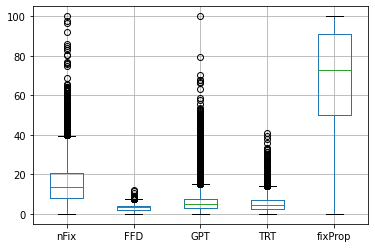

In [ ]:
boxplot = zuco_data.boxplot(column=['nFix','FFD','GPT','TRT','fixProp'])
#plt.ylabel('Reading time (s)')
plt.savefig('img/zuco.png')
#plt.xlabel('Reading time (s)')

### GECO

In [ ]:
!ls data/

dataloader.py		     predictions-models.csv    tutorial.ipynb
EnglishMaterial.xlsx	     Reviews.csv	       valid.article.filter.txt
evaluation_metric.py	     Reviews.csv.zip	       valid.title.filter.txt
Fixation_sequence.csv	     text_and_annorations.csv  wiki.en.vec.short50K
gold_data.csv		     train.article.txt	       zuco_dict.pkl
model.py		     training_data.csv
MonolingualReadingData.xlsx  train.title.txt


In [ ]:
from openpyxl import Workbook, load_workbook


In [ ]:
wb = load_workbook('data/MonolingualReadingData.xlsx', read_only=True)

In [ ]:
type(wb['DATA'])

openpyxl.worksheet.read_only.ReadOnlyWorksheet

In [ ]:
geco = pd.read_excel('data/MonolingualReadingData.xlsx',sheet_name = 'DATA')

In [ ]:
len(geco)

774015

In [ ]:
geco.head()

,PP_NR,GROUP,LANGUAGE_RANK,LANGUAGE,PART,TRIAL,TRIAL_FIXATION_COUNT,TRIAL_TOTAL_READING_TIME,WORD_ID_WITHIN_TRIAL,WORD_ID,WORD,WORD_AVERAGE_FIX_PUPIL_SIZE,WORD_FIXATION_COUNT,WORD_FIXATION_%,WORD_RUN_COUNT,WORD_FIRST_RUN_START_TIME,WORD_FIRST_RUN_END_TIME,WORD_FIRST_RUN_FIXATION_COUNT,WORD_FIRST_RUN_FIXATION_%,WORD_GAZE_DURATION,WORD_SECOND_RUN_START_TIME,WORD_SECOND_RUN_END_TIME,WORD_SECOND_RUN_FIXATION_COUNT,WORD_SECOND_RUN_FIXATION_%,WORD_THIRD_RUN_START_TIME,WORD_THIRD_RUN_END_TIME,WORD_THIRD_RUN_FIXATION_COUNT,WORD_THIRD_RUN_FIXATION_%,WORD_FIRST_FIXATION_DURATION,WORD_FIRST_FIXATION_INDEX,WORD_FIRST_FIXATION_RUN_INDEX,WORD_FIRST_FIXATION_TIME,WORD_FIRST_FIXATION_VISITED_WORD_COUNT,WORD_FIRST_FIXATION_X,WORD_FIRST_FIXATION_Y,WORD_FIRST_FIX_PROGRESSIVE,WORD_SECOND_FIXATION_DURATION,WORD_SECOND_FIXATION_RUN,WORD_SECOND_FIXATION_TIME,WORD_SECOND_FIXATION_X,WORD_SECOND_FIXATION_Y,WORD_THIRD_FIXATION_DURATION,WORD_THIRD_FIXATION_RUN,WORD_THIRD_FIXATION_TIME,WORD_THIRD_FIXATION_X,WORD_THIRD_FIXATION_Y,WORD_LAST_FIXATION_DURATION,WORD_LAST_FIXATION_RUN,WORD_LAST_FIXATION_TIME,WORD_LAST_FIXATION_X,WORD_LAST_FIXATION_Y,WORD_GO_PAST_TIME,WORD_SELECTIVE_GO_PAST_TIME,WORD_TOTAL_READING_TIME,WORD_TOTAL_READING_TIME_%,WORD_SPILLOVER,WORD_SKIP
0,pp21,monolingual,L1,English,1,5,115,25429,1,1-5-1,The,3782,2,0.0174,2,7,102,1,0.0087,95,357,643,1,0.0087,.,.,.,.,95,1,1,7,0,90.2,112.1,1,286,2,357,115.6,104.6,.,.,.,.,.,286,2,357,115.6,104.6,95,95,381,0.015,.,0
1,pp21,monolingual,L1,English,1,5,115,25429,2,1-5-2,intense,3701,3,0.0261,3,266,320,1,0.0087,54,766,1008,1,0.0087,1392,1924,1,0.0087,54,3,3,266,2,186.5,100.7,0,242,2,766,177.6,106.1,532,3,1392,163.8,107,532,3,1392,163.8,107,582,296,828,0.0326,.,1
2,pp21,monolingual,L1,English,1,5,115,25429,3,1-5-3,interest,3837.5,2,0.0174,2,1033,1366,1,0.0087,333,1957,2189,1,0.0087,.,.,.,.,333,6,6,1033,3,238.3,101.2,0,232,2,1957,229.4,96.6,.,.,.,.,.,232,2,1957,229.4,96.6,1097,565,565,0.0222,.,1
3,pp21,monolingual,L1,English,1,5,115,25429,4,1-5-4,aroused,3761.67,3,0.0261,2,150,228,1,0.0087,78,2226,2609,2,0.0174,.,.,.,.,78,2,2,150,1,327.9,132.8,1,215,2,2226,304,99,135,2,2474,356,103.8,135,2,2474,356,103.8,2107,428,428,0.0168,.,0
4,pp21,monolingual,L1,English,1,5,115,25429,5,1-5-5,in,3644,1,0.0087,1,2808,2962,1,0.0087,154,.,.,.,.,.,.,.,.,154,12,11,2808,5,403.2,114.5,0,.,.,.,.,.,.,.,.,.,.,154,1,2808,403.2,114.5,154,154,154,0.0061,.,1


In [ ]:
geco.to_csv('data/geco_whole.csv',index=False)

In [ ]:
geco = geco.drop(['GROUP'],axis = 1)
geco.head()

,PP_NR,LANGUAGE_RANK,LANGUAGE,PART,TRIAL,TRIAL_FIXATION_COUNT,TRIAL_TOTAL_READING_TIME,WORD_ID_WITHIN_TRIAL,WORD_ID,WORD,WORD_AVERAGE_FIX_PUPIL_SIZE,WORD_FIXATION_COUNT,WORD_FIXATION_%,WORD_RUN_COUNT,WORD_FIRST_RUN_START_TIME,WORD_FIRST_RUN_END_TIME,WORD_FIRST_RUN_FIXATION_COUNT,WORD_FIRST_RUN_FIXATION_%,WORD_GAZE_DURATION,WORD_SECOND_RUN_START_TIME,WORD_SECOND_RUN_END_TIME,WORD_SECOND_RUN_FIXATION_COUNT,WORD_SECOND_RUN_FIXATION_%,WORD_THIRD_RUN_START_TIME,WORD_THIRD_RUN_END_TIME,WORD_THIRD_RUN_FIXATION_COUNT,WORD_THIRD_RUN_FIXATION_%,WORD_FIRST_FIXATION_DURATION,WORD_FIRST_FIXATION_INDEX,WORD_FIRST_FIXATION_RUN_INDEX,WORD_FIRST_FIXATION_TIME,WORD_FIRST_FIXATION_VISITED_WORD_COUNT,WORD_FIRST_FIXATION_X,WORD_FIRST_FIXATION_Y,WORD_FIRST_FIX_PROGRESSIVE,WORD_SECOND_FIXATION_DURATION,WORD_SECOND_FIXATION_RUN,WORD_SECOND_FIXATION_TIME,WORD_SECOND_FIXATION_X,WORD_SECOND_FIXATION_Y,WORD_THIRD_FIXATION_DURATION,WORD_THIRD_FIXATION_RUN,WORD_THIRD_FIXATION_TIME,WORD_THIRD_FIXATION_X,WORD_THIRD_FIXATION_Y,WORD_LAST_FIXATION_DURATION,WORD_LAST_FIXATION_RUN,WORD_LAST_FIXATION_TIME,WORD_LAST_FIXATION_X,WORD_LAST_FIXATION_Y,WORD_GO_PAST_TIME,WORD_SELECTIVE_GO_PAST_TIME,WORD_TOTAL_READING_TIME,WORD_TOTAL_READING_TIME_%,WORD_SPILLOVER,WORD_SKIP
0,pp21,L1,English,1,5,115,25429,1,1-5-1,The,3782,2,0.0174,2,7,102,1,0.0087,95,357,643,1,0.0087,.,.,.,.,95,1,1,7,0,90.2,112.1,1,286,2,357,115.6,104.6,.,.,.,.,.,286,2,357,115.6,104.6,95,95,381,0.015,.,0
1,pp21,L1,English,1,5,115,25429,2,1-5-2,intense,3701,3,0.0261,3,266,320,1,0.0087,54,766,1008,1,0.0087,1392,1924,1,0.0087,54,3,3,266,2,186.5,100.7,0,242,2,766,177.6,106.1,532,3,1392,163.8,107,532,3,1392,163.8,107,582,296,828,0.0326,.,1
2,pp21,L1,English,1,5,115,25429,3,1-5-3,interest,3837.5,2,0.0174,2,1033,1366,1,0.0087,333,1957,2189,1,0.0087,.,.,.,.,333,6,6,1033,3,238.3,101.2,0,232,2,1957,229.4,96.6,.,.,.,.,.,232,2,1957,229.4,96.6,1097,565,565,0.0222,.,1
3,pp21,L1,English,1,5,115,25429,4,1-5-4,aroused,3761.67,3,0.0261,2,150,228,1,0.0087,78,2226,2609,2,0.0174,.,.,.,.,78,2,2,150,1,327.9,132.8,1,215,2,2226,304,99,135,2,2474,356,103.8,135,2,2474,356,103.8,2107,428,428,0.0168,.,0
4,pp21,L1,English,1,5,115,25429,5,1-5-5,in,3644,1,0.0087,1,2808,2962,1,0.0087,154,.,.,.,.,.,.,.,.,154,12,11,2808,5,403.2,114.5,0,.,.,.,.,.,.,.,.,.,.,154,1,2808,403.2,114.5,154,154,154,0.0061,.,1


In [ ]:
geco.describe()

,PART,TRIAL,TRIAL_FIXATION_COUNT,TRIAL_TOTAL_READING_TIME,WORD_ID_WITHIN_TRIAL,WORD_FIXATION_COUNT,WORD_FIXATION_%,WORD_RUN_COUNT,WORD_SKIP
count,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000
mean,2.406505,80.481298,82.450265,17210.411626,49.676996,0.806212,0.009977,0.718206,0.516321
std,1.100137,43.788243,22.036253,5341.424222,29.635053,0.828605,0.010202,0.677091,0.499734
min,1.000000,5.000000,1.000000,88.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,43.000000,67.000000,13200.000000,24.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,80.000000,79.000000,16449.000000,48.000000,1.000000,0.010400,1.000000,1.000000
75%,3.000000,118.000000,95.000000,20536.000000,73.000000,1.000000,0.015200,1.000000,1.000000
max,4.000000,164.000000,208.000000,49682.000000,143.000000,22.000000,0.169200,14.000000,1.000000


In [ ]:
geco = geco.drop(['LANGUAGE_RANK','LANGUAGE','PART','PP_NR','WORD_ID'],axis = 1)
geco.head()

,TRIAL,TRIAL_FIXATION_COUNT,TRIAL_TOTAL_READING_TIME,WORD_ID_WITHIN_TRIAL,WORD,WORD_AVERAGE_FIX_PUPIL_SIZE,WORD_FIXATION_COUNT,WORD_FIXATION_%,WORD_RUN_COUNT,WORD_FIRST_RUN_START_TIME,WORD_FIRST_RUN_END_TIME,WORD_FIRST_RUN_FIXATION_COUNT,WORD_FIRST_RUN_FIXATION_%,WORD_GAZE_DURATION,WORD_SECOND_RUN_START_TIME,WORD_SECOND_RUN_END_TIME,WORD_SECOND_RUN_FIXATION_COUNT,WORD_SECOND_RUN_FIXATION_%,WORD_THIRD_RUN_START_TIME,WORD_THIRD_RUN_END_TIME,WORD_THIRD_RUN_FIXATION_COUNT,WORD_THIRD_RUN_FIXATION_%,WORD_FIRST_FIXATION_DURATION,WORD_FIRST_FIXATION_INDEX,WORD_FIRST_FIXATION_RUN_INDEX,WORD_FIRST_FIXATION_TIME,WORD_FIRST_FIXATION_VISITED_WORD_COUNT,WORD_FIRST_FIXATION_X,WORD_FIRST_FIXATION_Y,WORD_FIRST_FIX_PROGRESSIVE,WORD_SECOND_FIXATION_DURATION,WORD_SECOND_FIXATION_RUN,WORD_SECOND_FIXATION_TIME,WORD_SECOND_FIXATION_X,WORD_SECOND_FIXATION_Y,WORD_THIRD_FIXATION_DURATION,WORD_THIRD_FIXATION_RUN,WORD_THIRD_FIXATION_TIME,WORD_THIRD_FIXATION_X,WORD_THIRD_FIXATION_Y,WORD_LAST_FIXATION_DURATION,WORD_LAST_FIXATION_RUN,WORD_LAST_FIXATION_TIME,WORD_LAST_FIXATION_X,WORD_LAST_FIXATION_Y,WORD_GO_PAST_TIME,WORD_SELECTIVE_GO_PAST_TIME,WORD_TOTAL_READING_TIME,WORD_TOTAL_READING_TIME_%,WORD_SPILLOVER,WORD_SKIP
0,5,115,25429,1,The,3782,2,0.0174,2,7,102,1,0.0087,95,357,643,1,0.0087,.,.,.,.,95,1,1,7,0,90.2,112.1,1,286,2,357,115.6,104.6,.,.,.,.,.,286,2,357,115.6,104.6,95,95,381,0.015,.,0
1,5,115,25429,2,intense,3701,3,0.0261,3,266,320,1,0.0087,54,766,1008,1,0.0087,1392,1924,1,0.0087,54,3,3,266,2,186.5,100.7,0,242,2,766,177.6,106.1,532,3,1392,163.8,107,532,3,1392,163.8,107,582,296,828,0.0326,.,1
2,5,115,25429,3,interest,3837.5,2,0.0174,2,1033,1366,1,0.0087,333,1957,2189,1,0.0087,.,.,.,.,333,6,6,1033,3,238.3,101.2,0,232,2,1957,229.4,96.6,.,.,.,.,.,232,2,1957,229.4,96.6,1097,565,565,0.0222,.,1
3,5,115,25429,4,aroused,3761.67,3,0.0261,2,150,228,1,0.0087,78,2226,2609,2,0.0174,.,.,.,.,78,2,2,150,1,327.9,132.8,1,215,2,2226,304,99,135,2,2474,356,103.8,135,2,2474,356,103.8,2107,428,428,0.0168,.,0
4,5,115,25429,5,in,3644,1,0.0087,1,2808,2962,1,0.0087,154,.,.,.,.,.,.,.,.,154,12,11,2808,5,403.2,114.5,0,.,.,.,.,.,.,.,.,.,.,154,1,2808,403.2,114.5,154,154,154,0.0061,.,1


In [ ]:
new = pd.DataFrame({'FFD':geco['WORD_FIRST_FIXATION_DURATION'], 'SFD':geco['WORD_SECOND_FIXATION_DURATION'],'GD':geco['WORD_GAZE_DURATION'],'TRT':geco['WORD_TOTAL_READING_TIME'],'GPT':geco['WORD_GO_PAST_TIME']})


In [ ]:
from tqdm import tqdm
new_FFD = []
new_SFD = []
new_GD = []
new_TRT = []
new_GPT = []
new_word = []
FFD, SFD, GD, TRT, GPT = 0,0,0,0,0
FFDn, SFDn, GDn, TRTn, GPTn = 0,0,0,0,0
for i in tqdm(range(len(geco))):
  if new['FFD'][i] == '.':
    new_FFD.append(0)
  else:
    new_FFD.append(new['FFD'][i])
    FFD+=new['FFD'][i]
    FFDn+=1
  
  if new['SFD'][i] == '.':
    new_SFD.append(0)
  else:
    new_SFD.append(new['SFD'][i])
    SFD+=new['SFD'][i]
    SFDn+=1

  if new['GD'][i] == '.':
    new_GD.append(0)
  else:
    new_GD.append(new['GD'][i])
    GD+=new['GD'][i]
    GDn+=1

  if new['TRT'][i] == '.':
    new_TRT.append(0)
  else:
    new_TRT.append(new['TRT'][i])
    TRT+=new['TRT'][i]
    TRTn+=1

  if new['GPT'][i] == '.':
    new_GPT.append(0)
  else:
    new_GPT.append(new['GPT'][i])
    GPT+=new['GPT'][i]
    GPTn+=1

  new_word.append(geco['WORD'][i])

100%|██████████| 774015/774015 [00:49<00:00, 15607.72it/s]


In [ ]:
new_word[0]

'The'

In [ ]:
for i in range(len(new_word)):
  new_word[i] = str(new_word[i]).replace('?','').replace('"','').replace('\'','').replace('......','').replace('!','').replace('.','').lower()

In [ ]:
(sum(new_FFD)/len(new_FFD),sum(new_SFD)/len(new_FFD),sum(new_GD)/len(new_FFD),sum(new_TRT)/len(new_FFD),sum(new_GPT)/len(new_FFD))


(129.27556701097524,
 29.252318107530215,
 143.2563554969865,
 168.1979935789358,
 203.7240466916016)

In [ ]:
for i in tqdm(range(len(new_word))):

  if new_FFD[i] == 0:
    new_FFD[i] = 129.27556701097524

  if new_SFD[i] == 0:
    new_SFD[i] = 29.252318107530215
  
  if new_GD[i] == 0:
    new_GD[i] = 143.2563554969865
  
  if new_TRT[i] == 0:
    new_TRT[i] = 168.1979935789358
  
  if new_GPT[i] == 0:
    new_GPT[i] = 203.7240466916016



100%|██████████| 774015/774015 [00:01<00:00, 488110.80it/s]


In [ ]:
new_FFD2 = []
new_SFD2 = []
new_GD2 = []
new_TRT2 = []
new_GPT2 = []
new_word2 = []
for i in tqdm(range(len(new_word))):

  if new_FFD[i] < 101 or new_FFD[i] > 502 or new_SFD[i] < 101 or new_SFD[i] > 490 or new_GD[i] < 101 or new_GD[i] > 695 or new_TRT[i] < 101 or new_TRT[i] > 1060 or new_GPT[i] < 101 or new_GPT[i] > 2140:
    continue
  else:
    new_FFD2.append(new_FFD[i])
    new_SFD2.append(new_SFD[i])
    new_GD2.append(new_GD[i])
    new_TRT2.append(new_TRT[i])
    new_GPT2.append(new_GPT[i])
    new_word2.append(new_word[i])

  

100%|██████████| 774015/774015 [00:01<00:00, 434197.25it/s]


In [ ]:
new_FFD_plot = []
new_SFD_plot = []
new_GD_plot = []
new_TRT_plot = []
new_GPT_plot = []
new_word_plot = []
for i in tqdm(range(len(new_word2))):
    new_FFD_plot.append(np.log(new_FFD2[i]))
    new_SFD_plot.append(np.log(new_SFD2[i]))
    new_GD_plot.append(np.log(new_GD2[i]))
    new_TRT_plot.append(np.log(new_TRT2[i]))
    new_GPT_plot.append(np.log(new_GPT2[i]))

  

100%|██████████| 86595/86595 [00:01<00:00, 79526.37it/s]


In [ ]:
new_FFD_ms = []
new_SFD_ms = []
new_GD_ms = []
new_TRT_ms = []
new_GPT_ms = []
for i in tqdm(range(len(new_word2))):
    new_FFD_ms.append(new_FFD2[i]*0.001)
    new_SFD_ms.append(new_SFD2[i]*0.001)
    new_GD_ms.append(new_GD2[i]*0.001)
    new_TRT_ms.append(new_TRT2[i]*0.001)
    new_GPT_ms.append(new_GPT2[i]*0.001)

  

100%|██████████| 86595/86595 [00:00<00:00, 477606.32it/s]


In [ ]:
len(Counter(new_word2))

6631

In [ ]:
small_geco_ms = pd.DataFrame({'FFD':new_FFD_ms, 'SFD':new_SFD_ms,'GD':new_GD_ms,'TRT':new_TRT_ms,'GPT':new_GPT_ms})
small_geco_ms

,FFD,SFD,GD,TRT,GPT
0,0.333,0.232,0.333,0.565,1.097
1,0.202,0.134,0.336,0.676,0.336
2,0.227,0.274,0.227,0.621,1.279
3,0.258,0.170,0.258,0.726,0.258
4,0.142,0.310,0.142,0.675,1.143
...,...,...,...,...,...
86590,0.152,0.188,0.152,0.340,0.152
86591,0.186,0.203,0.186,0.389,0.186
86592,0.175,0.192,0.367,0.674,0.367
86593,0.248,0.195,0.248,0.443,0.750


In [ ]:
small_geco_plot = pd.DataFrame({'FFD':new_FFD_plot, 'SFD':new_SFD_plot,'GD':new_GD_plot,'TRT':new_TRT_plot,'GPT':new_GPT_plot})
small_geco_plot

,FFD,SFD,GD,TRT,GPT
0,5.808142,5.446737,5.808142,6.336826,7.000334
1,5.308268,4.897840,5.817111,6.516193,5.817111
2,5.424950,5.613128,5.424950,6.431331,7.153834
3,5.552960,5.135798,5.552960,6.587550,5.552960
4,4.955827,5.736572,4.955827,6.514713,7.041412
...,...,...,...,...,...
86590,5.023881,5.236442,5.023881,5.828946,5.023881
86591,5.225747,5.313206,5.225747,5.963579,5.225747
86592,5.164786,5.257495,5.905362,6.513230,5.905362
86593,5.513429,5.273000,5.513429,6.093570,6.620073


In [ ]:
small_geco_filter = pd.DataFrame({'word':new_word2, 'FFD':new_FFD2, 'SFD':new_SFD2,'GD':new_GD2,'TRT':new_TRT2,'GPT':new_GPT2})
small_geco_filter

,word,FFD,SFD,GD,TRT,GPT
0,interest,333,232,333,565,1097
1,now,202,134,336,676,336
2,subsided,227,274,227,621,1279
3,in,258,170,258,726,258
4,view,142,310,142,675,1143
...,...,...,...,...,...,...
86590,are,152,188,152,340,152
86591,delightful,186,203,186,389,186
86592,neither,175,192,367,674,367
86593,finished,248,195,248,443,750


In [ ]:
small_geco_filter.to_csv('data/geco_small_filter.csv',index=False)

In [ ]:
small_geco = pd.DataFrame({'word':new_word, 'FFD':new_FFD, 'SFD':new_SFD,'GD':new_GD,'TRT':new_TRT,'GPT':new_GPT})
small_geco

,word,FFD,SFD,GD,TRT,GPT
0,the,95.000000,286.000000,95.000000,381.000000,95.000000
1,intense,54.000000,242.000000,54.000000,828.000000,582.000000
2,interest,333.000000,232.000000,333.000000,565.000000,1097.000000
3,aroused,78.000000,215.000000,78.000000,428.000000,2107.000000
4,in,154.000000,29.252318,154.000000,154.000000,154.000000
...,...,...,...,...,...,...
774010,"again,",435.000000,29.252318,435.000000,435.000000,435.000000
774011,who,129.275567,29.252318,143.256355,168.197994,203.724047
774012,knows,270.000000,29.252318,270.000000,270.000000,270.000000
774013,and,129.275567,29.252318,143.256355,168.197994,203.724047


In [ ]:
small_geco.describe()

,FFD,SFD,GD,TRT,GPT
count,774015.000000,774015.000000,774015.000000,774015.000000,774015.000000
mean,179.692729,54.131046,199.125992,233.794809,283.175938
std,80.213134,69.678767,103.946196,146.369750,305.482237
min,2.000000,4.000000,2.000000,2.000000,2.000000
25%,129.275567,29.252318,143.256355,168.197994,203.724047
50%,141.000000,29.252318,147.000000,168.197994,203.724047
75%,216.000000,29.252318,231.000000,258.000000,277.000000
max,2689.000000,1990.000000,3909.000000,6978.000000,21041.000000


In [ ]:
small_geco.to_csv('data/geco_small.csv',index=False)

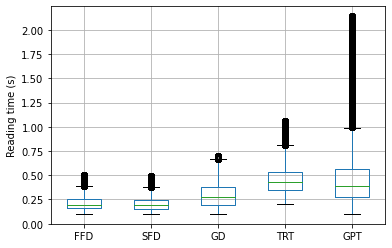

In [ ]:
boxplot = small_geco_ms.boxplot(column=['FFD','SFD','GD','TRT','GPT'])
plt.ylabel('Reading time (s)')
plt.savefig('img/small_geco_s.png')
#plt.xlabel('Reading time (s)')

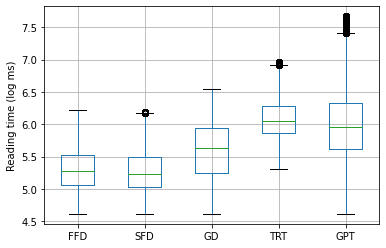

In [ ]:
boxplot = small_geco_plot.boxplot(column=['FFD','SFD','GD','TRT','GPT'])
plt.ylabel('Reading time (log ms)')
plt.savefig('img/small_geco_logms.png')
#plt.ylim(0, 100)

In [ ]:
# word: 'word' feature: 'WORD_FIXATION', 'WORD_RUN_COUNT', 'WORD_FIRST_FIXATION_DURATION(FFD)', 'WORD_SECOND_FIXATION_DURATION(SFD)', 'WORD_GO_PAST_TIME(GPT)','WORD_TOTAL_READING_TIME_%', 'WORD_GAZE_DURATION(GD)'
# english material

,WORD_ID,SENTENCE_ID,CHRON_ID,WORD,PART_OF_SPEECH,CONTENT_WORD,WORD_LENGTH,IA_AREA,IA_TOP,IA_BOTTOM,IA_LEFT,IA_RIGHT
0,1-5-1,1-1,1,The,Article,0,3,3087,93,142,66,129
1,1-5-2,1-1,2,intense,Adjective,1,7,3920,93,142,129,209
2,1-5-3,1-1,3,interest,Noun,1,8,4410,93,142,209,299
3,1-5-4,1-1,4,aroused,Verb,1,7,3969,93,142,299,380
4,1-5-5,1-1,5,in,Preposition,0,2,1421,93,142,380,409


In [ ]:
from collections import Counter

In [ ]:
len(Counter(geco['WORD']))

9875

### yindu

In [ ]:
!ls data/

dataloader.py		Reviews.csv		  tutorial.ipynb
evaluation_metric.py	Reviews.csv.zip		  valid.article.filter.txt
Fixation_sequence.csv	text_and_annorations.csv  valid.title.filter.txt
gold_data.csv		train.article.txt	  wiki.en.vec.short50K
model.py		training_data.csv	  zuco_dict.pkl
predictions-models.csv	train.title.txt


In [ ]:
anno = pd.read_csv('data/Fixation_sequence.csv')

In [ ]:
anno

,Participant_ID,Text_ID,Word_ID,Word,Fixation_Duration
0,P1,1,1,Aspect--Work,280
1,P1,1,3,work,275
2,P1,1,3,work,227
3,P1,1,4,40,219
4,P1,1,5,hours,211
...,...,...,...,...,...
160998,P7,1000,16,this,153
160999,P7,1000,19,this,469
161000,P7,1000,21,for,200
161001,P7,1000,23,and,309


### Option1: Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler,Normalizer
original_feature = [list(zuco_data['nFix']), list(zuco_data['FFD']), list(zuco_data['GPT']),list(zuco_data['TRT']),list(zuco_data['fixProp'])]
norm = Normalizer()
transformed_feature = norm.fit_transform(original_feature)

In [ ]:
NEW = small_geco_filter.drop(['word'],axis = 1)
NEW.values

array([[ 333,  232,  333,  565, 1097],
       [ 202,  134,  336,  676,  336],
       [ 227,  274,  227,  621, 1279],
       ...,
       [ 175,  192,  367,  674,  367],
       [ 248,  195,  248,  443,  750],
       [ 458,  190,  458,  648,  458]])

In [ ]:
NEW.values.shape

(432975, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler,Normalizer
original_feature = NEW.values
norm = Normalizer()
transformed_feature = norm.fit_transform(original_feature)

In [ ]:
np.mean(transformed_feature,axis = 0)

array([0.27126282, 0.26374923, 0.37945753, 0.57808081, 0.54477145])

In [ ]:
# normalization and standardization
feature_list = ['nFix','FFD','GPT','TRT','fixProp']
for feature in range(len(feature_list)):
  zuco_data[feature_list[feature]] = transformed_feature[feature]
zuco_data

In [ ]:
# normalization and standardization
feature_list = ['nFix','FFD','GPT','TRT','fixProp']
for feature in range(len(feature_list)):
  zuco_data[feature_list[feature]] = transformed_feature[feature]
zuco_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,carlucci,0.011466,0.009584,0.005132,0.011550,0.009421
1,0,1,was,0.005241,0.007295,0.004364,0.005098,0.007654
2,0,2,deputy,0.010155,0.011992,0.008228,0.010212,0.010009
3,0,3,defense,0.008190,0.010860,0.006708,0.009334,0.008832
4,0,4,secretary,0.007207,0.008537,0.003736,0.006349,0.008832
...,...,...,...,...,...,...,...,...
19285,990,5,pursued,0.006961,0.009108,0.006242,0.005791,0.010009
19286,990,6,a,0.001392,0.002128,0.000855,0.001151,0.002502
19287,990,7,career,0.005569,0.006427,0.003310,0.003926,0.008341
19288,990,8,in,0.000464,0.000525,0.000211,0.000284,0.000834


In [ ]:
zuco_data.describe()

,sentence_id,word_id,nFix,FFD,GPT,TRT,fixProp
count,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000
mean,491.344220,11.506013,0.006102,0.006578,0.005266,0.005931,0.006712
std,285.799696,9.228118,0.003822,0.002928,0.004910,0.004082,0.002606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,243.000000,4.000000,0.003249,0.004395,0.002399,0.002926,0.005005
50%,494.000000,10.000000,0.005569,0.006845,0.004133,0.005234,0.007280
75%,734.000000,16.000000,0.008354,0.008732,0.006411,0.008036,0.009099
max,990.000000,64.000000,0.040375,0.025265,0.082895,0.045873,0.010009


### Option2 Normalization and standardization

In [ ]:
# normalization and standardization
for feature in ['nFix','FFD','GPT','TRT','fixProp']:
  zuco_data[feature] = standardization(normalization(zuco_data[feature]))
zuco_data

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp
0,0,0,carlucci,1.403443,1.026587,-0.027343,1.376635,1.039546
1,0,1,was,-0.225168,0.245046,-0.183784,-0.204166,0.361622
2,0,2,deputy,1.060578,1.849171,0.603333,1.048795,1.265520
3,0,3,defense,0.546280,1.462676,0.293728,0.833774,0.813571
4,0,4,secretary,0.289131,0.669165,-0.311557,0.102438,0.813571
...,...,...,...,...,...,...,...,...
19285,990,5,pursued,0.224843,0.864122,0.198683,-0.034439,1.265520
19286,990,6,a,-1.232335,-1.519833,-0.898414,-1.171096,-1.615655
19287,990,7,career,-0.139451,-0.051665,-0.398310,-0.491358,0.625259
19288,990,8,in,-1.475198,-2.067368,-1.029532,-1.383573,-2.255916


In [ ]:
zuco_data.describe()

,sentence_id,word_id,nFix,FFD,GPT,TRT,fixProp
count,19290.000000,19290.000000,1.929000e+04,1.929000e+04,1.929000e+04,1.929000e+04,1.929000e+04
mean,491.344220,11.506013,-1.865602e-14,3.386692e-15,-6.024419e-15,-2.584189e-18,2.888559e-14
std,285.799696,9.228118,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,0.000000,0.000000,-1.596630e+00,-2.246649e+00,-1.072465e+00,-1.453145e+00,-2.576047e+00
25%,243.000000,4.000000,-7.466089e-01,-7.454440e-01,-5.839633e-01,-7.361996e-01,-6.552635e-01
50%,494.000000,10.000000,-1.394513e-01,9.123324e-02,-2.307378e-01,-1.708733e-01,2.178200e-01
75%,734.000000,16.000000,5.891379e-01,7.357183e-01,2.331804e-01,5.155565e-01,9.162867e-01
max,990.000000,64.000000,8.967913e+00,6.382471e+00,1.580984e+01,9.785566e+00,1.265520e+00


## Embedding dict with cognitive data 

In [ ]:
import pickle

In [ ]:
#geco
feature_unknow0 = [0,0,0,0,0]
feature_unknow = [0.27126282, 0.26374923, 0.37945753, 0.57808081, 0.54477145]

In [ ]:
((transformed_feature[0] + transformed_feature[1])/2).tolist()

[0.241451711873843,
 0.16430932265568152,
 0.31925734220043145,
 0.6031783055074356,
 0.6041229496979621]

In [ ]:
# zuco embeddding
geco_dict = {}
for i in tqdm(range(len(new_word2))):
  word = new_word2[i]
  feature_data = geco_dict.get(word,transformed_feature[i])
  geco_dict[word] = ((feature_data + transformed_feature[i])/2).tolist()
geco_dict['<UNKNOW>'] = feature_unknow
geco_dict['<UNKNOW0>'] = feature_unknow0

100%|██████████| 86595/86595 [00:00<00:00, 93092.32it/s]


In [ ]:
# save geco embedding
a_file = open("data/geco_dict.pkl", "wb")
pickle.dump(geco_dict, a_file)
a_file.close()

In [27]:
# load geco embedding
import pickle
a_file = open("data/geco_dict.pkl", "rb")
geco_dict = pickle.load(a_file)
a_file.close()

In [28]:
len(geco_dict)

6633

In [ ]:
feature_unknow0 = [0,0,0,0,0]
feature_unknow = [sum(zuco_data['nFix'])/len(zuco_data['nFix']),sum(zuco_data['FFD'])/len(zuco_data['FFD']),sum(zuco_data['GPT'])/len(zuco_data['GPT']),sum(zuco_data['TRT'])/len(zuco_data['TRT']),sum(zuco_data['fixProp'])/len(zuco_data['fixProp'])]
feature_unknow

[0.006101986299565626,
 0.006577844761814167,
 0.005265982548220093,
 0.005931285945408052,
 0.006712034720019549]

In [ ]:
# zuco embeddding
zuco_dict = {}
for i in tqdm(range(len(zuco_data))):
  word = zuco_data['word'][i]
  feature_data = zuco_dict.get(word,zuco_data.iloc[i][3::])
  zuco_dict[word] = list((feature_data + zuco_data.iloc[i][3::])/2)

100%|██████████| 19290/19290 [00:12<00:00, 1486.93it/s]


In [ ]:
zuco_dict['<UNKNOW>'] = feature_unknow
zuco_dict['<UNKNOW0>'] = feature_unknow0

In [ ]:
print('number of words in zuco:', len(zuco_dict))

number of words in zuco: 6259


In [ ]:
# save zuco embedding
a_file = open("data/zuco_dict.pkl", "wb")
pickle.dump(zuco_dict, a_file)
a_file.close()

In [29]:
# load zuco embedding
a_file = open("data/zuco_dict.pkl", "rb")
zuco_dict = pickle.load(a_file)
a_file.close()

In [30]:
len(zuco_dict)

6259

In [ ]:
zuco_dict['<UNKNOW>']

[0.006101986299565626,
 0.006577844761814167,
 0.005265982548220093,
 0.005931285945408052,
 0.006712034720019549]

## Embedding matrix with cognitive data

In [32]:
embedding_index_word = list(embeddings_index.keys())
len(embeddings_index)

49999

In [ ]:
embeddings_index_geco = {}
for i in range(len(embedding_index_word)):
  embeddings_index_geco[embedding_index_word[i]] = np.hstack((embeddings_index[embedding_index_word[i]],geco_dict.get(embedding_index_word[i],geco_dict['<UNKNOW0>'])))
  

In [ ]:
embeddings_index_zugeco = {}
for i in range(len(embedding_index_word)):
  a = np.hstack((embeddings_index[embedding_index_word[i]],geco_dict.get(embedding_index_word[i],geco_dict['<UNKNOW0>'])))
  embeddings_index_zugeco[embedding_index_word[i]] = np.hstack((a,zuco_dict.get(embedding_index_word[i],zugeco_dict['<UNKNOW0>'])))
  

In [ ]:
embeddings_index_zugeco = {}
for i in range(len(embedding_index_word)):
  a = np.hstack((embeddings_index[embedding_index_word[i]],geco_dict.get(embedding_index_word[i],geco_dict['<UNKNOW>'])))
  embeddings_index_zugeco[embedding_index_word[i]] = np.hstack((a,zuco_dict.get(embedding_index_word[i],zuco_dict['<UNKNOW>'])))
  

In [33]:
embeddings_index_geco = {}
for i in range(len(embedding_index_word)):
  embeddings_index_geco[embedding_index_word[i]] = np.hstack((embeddings_index[embedding_index_word[i]],geco_dict.get(embedding_index_word[i],geco_dict['<UNKNOW>'])))
  

In [ ]:
len(embeddings_index_zugeco['was'])

310

In [ ]:
word_index = x_tokenizer.word_index
embedding_matrix_zugeco = np.zeros((len(word_index) + 1, len(embeddings_index_zugeco['was'])))
for word, i in word_index.items():
    embedding_vector = embeddings_index_zugeco.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_zugeco[i] = embedding_vector

In [36]:
word_index = x_tokenizer.word_index
embedding_matrix_geco = np.zeros((len(word_index) + 1, len(embeddings_index_geco['was'])))
for word, i in word_index.items():
    embedding_vector = embeddings_index_geco.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_geco[i] = embedding_vector

In [ ]:
len(embedding_matrix_geco[0])

305

In [ ]:
embedding_index_word = list(embeddings_index.keys())
len(embeddings_index)

49999

In [ ]:
embeddings_index_zuco = {}
for i in range(len(embedding_index_word)):
  embeddings_index_zuco[embedding_index_word[i]] = np.hstack((embeddings_index[embedding_index_word[i]],zuco_dict.get(embedding_index_word[i],zuco_dict['<UNKNOW0>'])))


In [ ]:
word_index = x_tokenizer.word_index
embedding_matrix_zuco = np.zeros((len(word_index) + 1, len(embeddings_index_zuco['was'])))
for word, i in word_index.items():
    embedding_vector = embeddings_index_zuco.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_zuco[i] = embedding_vector

In [ ]:
len(embedding_matrix_zuco[0])

305

## train

### zuco

In [ ]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
embedding_size = len(embedding_matrix_zuco[0])

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_zuco],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_zuco],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 305)      34953610    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1612000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 514s 1ms/sample - loss: 2.8493 - val_loss: 2.4892
Epoch 2/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.3813 - val_loss: 2.2705
Epoch 3/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.2182 - val_loss: 2.1790
Epoch 4/50
353899/353899 [==============================] - 514s 1ms/sample - loss: 2.1166 - val_loss: 2.1309
Epoch 5/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.0396 - val_loss: 2.0932
Epoch 6/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.9759 - val_loss: 2.0789
Epoch 7/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.9191 - val_loss: 2.0641
Epoch 8/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.8670 - val_loss: 2.0643
Epoch 00008: early stopping


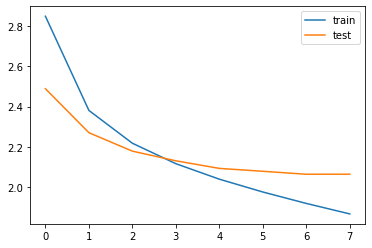

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.savefig('img/zucolossbig.png')
pyplot.show()

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


100%|██████████| 39323/39323 [49:57<00:00, 13.12it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

(0.14125026981349809, 0.03338376740714922, 0.13968419520192737)

In [ ]:

zuco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
zuco_result.to_csv('data/zuco_result_unknow_big.csv')

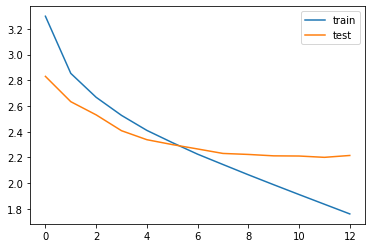

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.savefig('img/zucoloss.png')
pyplot.show()

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


100%|██████████| 8836/8836 [11:26<00:00, 12.88it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

(0.12654010483013275, 0.027974518400627615, 0.12484823592009867)

In [ ]:

zuco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
zuco_result.to_csv('data/zuco_result_unknow.csv')

### geco

In [37]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
embedding_size = len(embedding_matrix_geco[0])

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_geco],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_geco],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 305)      33546035    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1612000     embedding[0][0]                  
_____________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 275255 samples, validate on 39322 samples
Epoch 1/50
275255/275255 [==============================] - 400s 1ms/sample - loss: 2.9641 - val_loss: 2.6175
Epoch 2/50
275255/275255 [==============================] - 388s 1ms/sample - loss: 2.5253 - val_loss: 2.3639
Epoch 3/50
275255/275255 [==============================] - 388s 1ms/sample - loss: 2.3314 - val_loss: 2.2612
Epoch 4/50
275255/275255 [==============================] - 388s 1ms/sample - loss: 2.2131 - val_loss: 2.1999
Epoch 5/50
275255/275255 [==============================] - 388s 1ms/sample - loss: 2.1255 - val_loss: 2.1614
Epoch 6/50
275255/275255 [==============================] - 388s 1ms/sample - loss: 2.0528 - val_loss: 2.1349
Epoch 7/50
275255/275255 [==============================] - 389s 1ms/sample - loss: 1.9866 - val_loss: 2.1227
Epoch 8/50
275255/275255 [==============================] - 389s 1ms/sample - loss: 1

In [43]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [41]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow_0101.csv')
print(sum(f1_list)/len(f1_list))
print(sum(f2_list)/len(f2_list))
print(sum(fl_list)/len(fl_list))

100%|██████████| 39322/39322 [49:26<00:00, 13.26it/s]


0.13935596201259373
0.02990909669161429
0.13779645220483064


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 509s 1ms/sample - loss: 2.8290 - val_loss: 2.4541
Epoch 2/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 2.3609 - val_loss: 2.2548
Epoch 3/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 2.1991 - val_loss: 2.1555
Epoch 4/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 2.1005 - val_loss: 2.1214
Epoch 5/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 2.0255 - val_loss: 2.0936
Epoch 6/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 1.9610 - val_loss: 2.0680
Epoch 7/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 1.9014 - val_loss: 2.0637
Epoch 8/50
353899/353899 [==============================] - 506s 1ms/sample - loss: 1

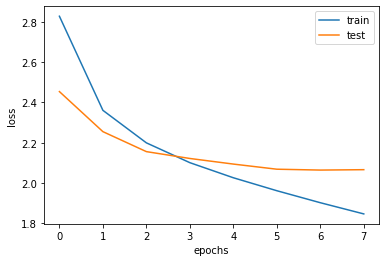

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend() 
#pyplot.savefig('img/geco_loss2.png')
pyplot.show()

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 516s 1ms/sample - loss: 2.8584 - val_loss: 2.5140
Epoch 2/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.4032 - val_loss: 2.2739
Epoch 3/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.2217 - val_loss: 2.1715
Epoch 4/50
353899/353899 [==============================] - 510s 1ms/sample - loss: 2.1170 - val_loss: 2.1292
Epoch 5/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.0399 - val_loss: 2.0980
Epoch 6/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.9749 - val_loss: 2.0837
Epoch 7/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.9180 - val_loss: 2.0700
Epoch 8/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 1.8640 - val_loss: 2.0663
Epoch 9/50
353899/353899 [==============================] - 511s 1ms/

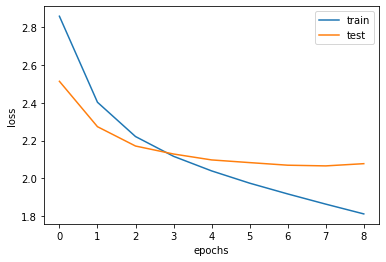

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend() 
pyplot.savefig('img/geco_loss2.png')
pyplot.show()

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow0.csv')
print(sum(f1_list)/len(f1_list))
print(sum(f2_list)/len(f2_list))
print(sum(fl_list)/len(fl_list))

100%|██████████| 39323/39323 [40:00<00:00, 16.38it/s]


0.1412639716110616
0.033725998178707355
0.13967473874162048


In [ ]:

geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow_big.csv')

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow0.csv')
print(sum(f1_list)/len(f1_list))
print(sum(f2_list)/len(f2_list))
print(sum(fl_list)/len(fl_list))

100%|██████████| 39323/39323 [51:33<00:00, 12.71it/s]


0.14332154805714653
0.03327625598203144
0.14167491278352207


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

In [ ]:
seq2summary(y_val[0])


'do not recommend the seller '

In [ ]:
decode_sequence(x_val[0].reshape(1,max_len_text))

' great product but'

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 107s 1ms/sample - loss: 3.2756 - val_loss: 2.8273
Epoch 2/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.8664 - val_loss: 2.6540
Epoch 3/50
79516/79516 [==============================] - 101s 1ms/sample - loss: 2.6996 - val_loss: 2.5596
Epoch 4/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.5753 - val_loss: 2.4768
Epoch 5/50
79516/79516 [==============================] - 99s 1ms/sample - loss: 2.4719 - val_loss: 2.3871
Epoch 6/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.3743 - val_loss: 2.3571
Epoch 7/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.2835 - val_loss: 2.3059
Epoch 8/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.2072 - val_loss: 2.2634
Epoch 9/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.1243

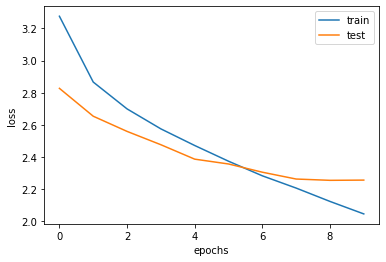

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend() 
pyplot.savefig('img/geco_loss.png')
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


100%|██████████| 8836/8836 [09:53<00:00, 14.90it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

(0.11453031342843148, 0.024015764844142543, 0.11318214716698353)

In [ ]:
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: this is really good with a rich and intense lemon flavor i did not want to use alone as much as i wanted to use for a base for a dressing or glaze ala recipes seen on cooking channel i am well satisfied 
Original summary: versatile 
Predicted summary:  good but not great


Review: my dog won't touch these she likes almost everything so i was very surprised the bones smell like they have been burned maybe it's just the jerky smell but it's very unpleasant 
Original summary: dog does not like 
Predicted summary:  not bad but not great


Review: i love chai and this is hands down the best i have ever bought absolutely delicious coincidentally a good friend of mine was at my house a few days ago and saw the product sitting on my kitchen table and said boy that is really good it is the brand i always buy i have to agree it is truly delicious it will be the only brand i buy from now on 
Original summary: best chai ever 
Predicted summary:  my favorite chai


Review: my first food pur

In [ ]:
geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow.csv')

### geco_average

In [ ]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
embedding_size = len(embedding_matrix_geco[0])

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_geco],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_geco],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 305)      34953610    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1612000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.8524 - val_loss: 2.4759
Epoch 2/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 2.3837 - val_loss: 2.2635
Epoch 3/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 2.2178 - val_loss: 2.1813
Epoch 4/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 2.1183 - val_loss: 2.1360
Epoch 5/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 2.0426 - val_loss: 2.0912
Epoch 6/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 1.9789 - val_loss: 2.0708
Epoch 7/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 1.9227 - val_loss: 2.0722
Epoch 8/50
353899/353899 [==============================] - 507s 1ms/sample - loss: 1.8702 - val_loss: 2.0592
Epoch 9/50
353899/353899 [==============================] - 507s 1ms/

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

print(sum(f1_list)/len(f1_list))
print(sum(f2_list)/len(f2_list))
print(sum(fl_list)/len(fl_list))

100%|██████████| 39323/39323 [40:35<00:00, 16.14it/s]

0.14276847511665947
0.03371772732398523
0.14109469099331923


In [ ]:
geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_average.csv')

In [ ]:
(len(x_tr),len(x_val))

(79516, 8836)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 107s 1ms/sample - loss: 3.2925 - val_loss: 2.8375
Epoch 2/50
79516/79516 [==============================] - 101s 1ms/sample - loss: 2.8767 - val_loss: 2.6753
Epoch 3/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.7133 - val_loss: 2.5595
Epoch 4/50
79516/79516 [==============================] - 100s 1ms/sample - loss: 2.5905 - val_loss: 2.5006
Epoch 5/50
79516/79516 [==============================] - 104s 1ms/sample - loss: 2.4941 - val_loss: 2.3948
Epoch 6/50
79516/79516 [==============================] - 109s 1ms/sample - loss: 2.3949 - val_loss: 2.3689
Epoch 7/50
79516/79516 [==============================] - 111s 1ms/sample - loss: 2.3027 - val_loss: 2.3133
Epoch 8/50
79516/79516 [==============================] - 105s 1ms/sample - loss: 2.2184 - val_loss: 2.2753
Epoch 9/50
79516/79516 [==============================] - 101s 1ms/sample - loss: 2.141

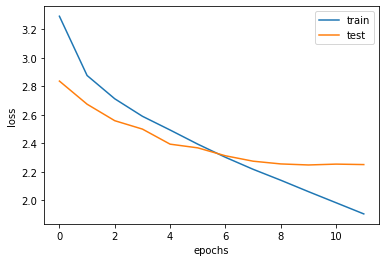

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend() 
pyplot.savefig('img/geco0_loss.png')
pyplot.show()

In [ ]:
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_val))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

100%|██████████| 8836/8836 [09:49<00:00, 14.98it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

(0.11681921575311789, 0.025364191363992705, 0.11558386013049607)

In [ ]:

geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/geco_result_unknow.csv')

### low dimension embedding glove+geco

In [ ]:
pca = PCA(n_components=5)
principalComponents_5 = pca.fit_transform(embedding_matrix)

In [ ]:
len(principalComponents_5)

57476

In [ ]:
embedding_matrix_low = np.zeros((len(word_index) + 1, 10))
for i in range(len(principalComponents_5)):
    embedding_matrix_low[i] = np.hstack((principalComponents_5[i],embedding_matrix_geco[i][300:305]))
embedding_matrix_low.shape

(57476, 10)

In [ ]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
embedding_size = len(embedding_matrix_low[0])

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_low],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_low],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 10)       574760      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1022000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 109s 1ms/sample - loss: 3.5892 - val_loss: 3.2434
Epoch 2/50
79516/79516 [==============================] - 98s 1ms/sample - loss: 3.2183 - val_loss: 3.0036
Epoch 3/50
79516/79516 [==============================] - 97s 1ms/sample - loss: 3.0913 - val_loss: 2.9259
Epoch 4/50
79516/79516 [==============================] - 97s 1ms/sample - loss: 3.0604 - val_loss: 2.8953
Epoch 5/50
79516/79516 [==============================] - 97s 1ms/sample - loss: 2.9932 - val_loss: 2.8827
Epoch 6/50
79516/79516 [==============================] - 101s 1ms/sample - loss: 2.9612 - val_loss: 2.8683
Epoch 7/50
79516/79516 [==============================] - 97s 1ms/sample - loss: 2.9278 - val_loss: 2.8181
Epoch 8/50
79516/79516 [==============================] - 97s 1ms/sample - loss: 2.8997 - val_loss: 2.8315
Epoch 00008: early stopping


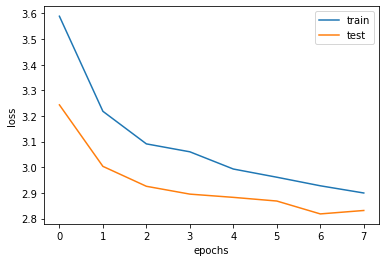

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.legend() 
pyplot.savefig('img/low_loss.png')
pyplot.show()

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


  0%|          | 31/8836 [01:15<5:55:18,  2.42s/it]

In [ ]:
geco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
geco_result.to_csv('data/gecoglove_low.csv')

### GECO + ZUCO 000

In [ ]:
#from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 
embedding_size = len(embedding_matrix_zugeco[0])

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_zugeco],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, embedding_size, weights=[embedding_matrix_zugeco],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 310)      35526620    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 1622000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
#average 
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 2.8565 - val_loss: 2.4944
Epoch 2/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 2.3879 - val_loss: 2.2828
Epoch 3/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 2.2185 - val_loss: 2.1845
Epoch 4/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 2.1165 - val_loss: 2.1360
Epoch 5/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 2.0387 - val_loss: 2.1073
Epoch 6/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 1.9723 - val_loss: 2.0781
Epoch 7/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 1.9133 - val_loss: 2.0725
Epoch 8/50
353899/353899 [==============================] - 508s 1ms/sample - loss: 1.8598 - val_loss: 2.0719
Epoch 9/50
353899/353899 [==============================] - 508s 1ms/

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_val))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_val[i]),decode_sequence(x_val[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)

100%|██████████| 39323/39323 [40:12<00:00, 16.30it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))

(0.13997505731076948, 0.03369289997128026, 0.13844465677860013)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 353899 samples, validate on 39323 samples
Epoch 1/50
353899/353899 [==============================] - 522s 1ms/sample - loss: 2.8526 - val_loss: 2.5123
Epoch 2/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.3795 - val_loss: 2.2766
Epoch 3/50
353899/353899 [==============================] - 511s 1ms/sample - loss: 2.2154 - val_loss: 2.1814
Epoch 4/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 2.1182 - val_loss: 2.1285
Epoch 5/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 2.0460 - val_loss: 2.0938
Epoch 6/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 1.9846 - val_loss: 2.0719
Epoch 7/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 1.9298 - val_loss: 2.0587
Epoch 8/50
353899/353899 [==============================] - 512s 1ms/sample - loss: 1

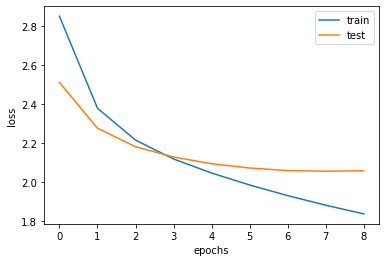

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.savefig('img/zugecoloss2.png')
pyplot.show()

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 108s 1ms/sample - loss: 3.3017 - val_loss: 2.8478
Epoch 2/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.8351 - val_loss: 2.6161
Epoch 3/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.6602 - val_loss: 2.5021
Epoch 4/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.5193 - val_loss: 2.4134
Epoch 5/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.3962 - val_loss: 2.3257
Epoch 6/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.2962 - val_loss: 2.2893
Epoch 7/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.2057 - val_loss: 2.2358
Epoch 8/50
79516/79516 [==============================] - 103s 1ms/sample - loss: 2.1238 - val_loss: 2.2114
Epoch 9/50
79516/79516 [==============================] - 102s 1ms/sample - loss: 2.044

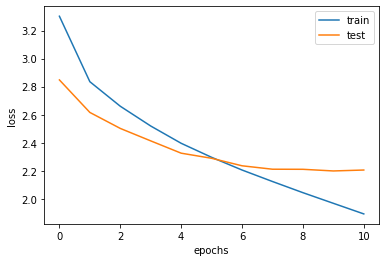

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.xlabel('epochs')
pyplot.ylabel('loss')
pyplot.savefig('img/zugecoloss.png')
pyplot.show()

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index


# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
from tqdm import tqdm
f1_list = []
f2_list = []
fl_list = []
error = []
for i in tqdm(range(len(x_test))):
  try:
    f1,f2,fl = rouge_score(seq2summary(y_test[i]),decode_sequence(x_test[i].reshape(1,max_len_text)))
    f1_list.append(f1)
    f2_list.append(f2)
    fl_list.append(fl)
  except:
    error.append(i)


100%|██████████| 39323/39323 [49:41<00:00, 13.19it/s]


In [ ]:
(sum(f1_list)/len(f1_list),sum(f2_list)/len(f2_list),sum(fl_list)/len(fl_list))


(0.14336414966181227, 0.03305209285051722, 0.1416075001645805)

In [ ]:
zugeco_result = pd.DataFrame({'f1':f1_list,'f2':f2_list,'fl':fl_list})
zugeco_result.to_csv('data/zugeco_result_unknow0.csv')

# Visualization

In [ ]:
word_visul = []
for word, i in word_index.items():
  word_visul.append(word)
len(word_visul)

57475

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(embedding_matrix_geco)


In [ ]:
principalComponents.shape

(57476, 2)

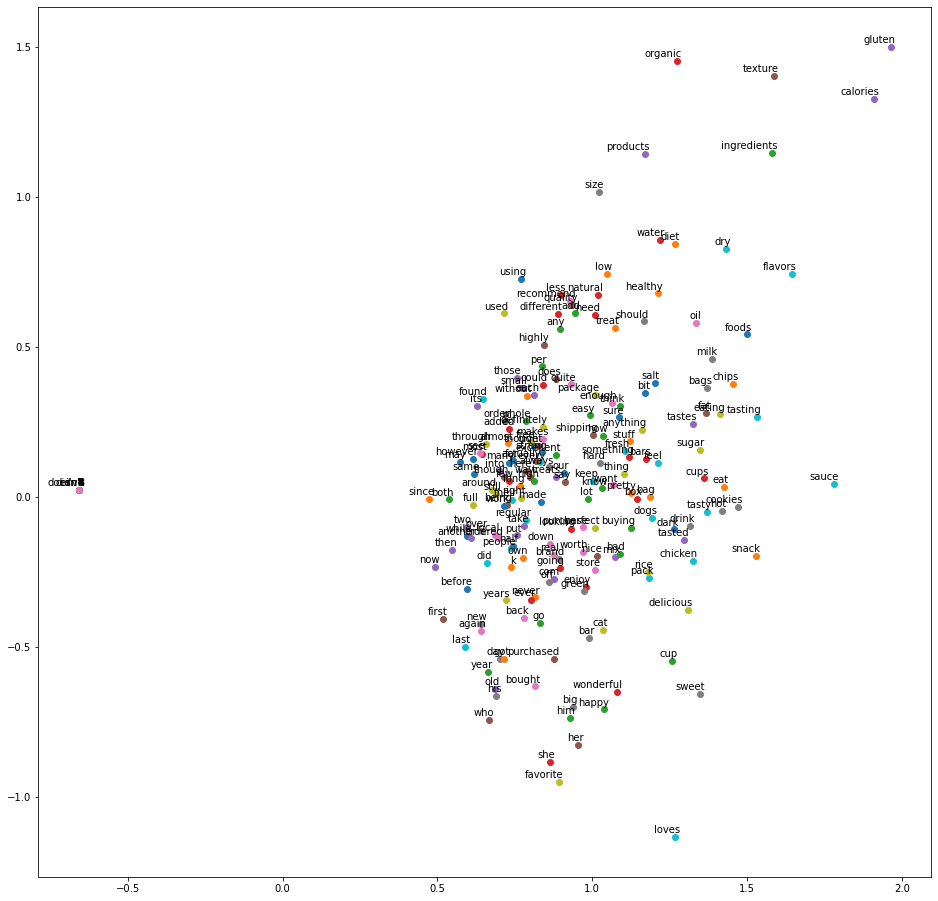

In [ ]:
plt.figure(figsize=(16, 16)) 
x = principalComponents
for i in range(101,301):
  plt.scatter(x[i][0],x[i][1])
  plt.annotate(word_visul[i-1],
               xy=(x[i][0], x[i][1]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.savefig('img/visulgeco.png')

In [ ]:
pca = PCA(n_components=2)
principalComponents2 = pca.fit_transform(embedding_matrix)

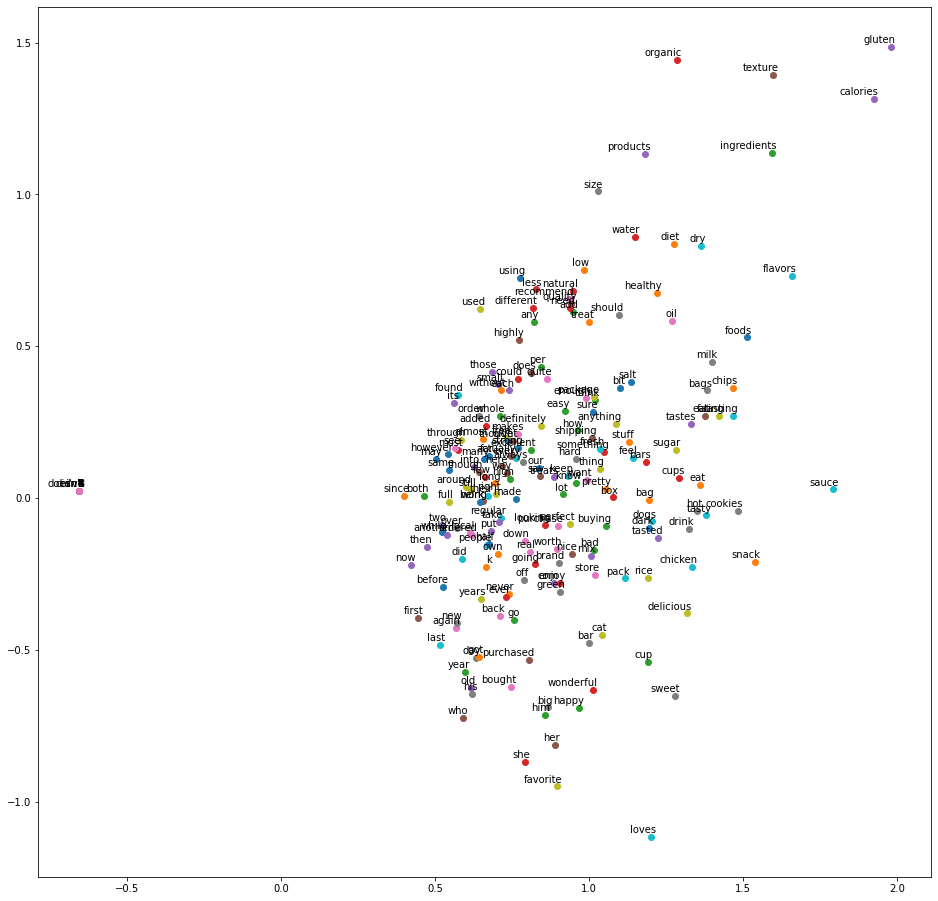

In [ ]:
plt.figure(figsize=(16, 16)) 
x = principalComponents2
for i in range(101,301):
  plt.scatter(x[i][0],x[i][1])
  plt.annotate(word_visul[i-1],
               xy=(x[i][0], x[i][1]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.savefig('img/visulglove.png')

In [ ]:
pca = PCA(n_components=2)
principalComponents3 = pca.fit_transform(embedding_matrix_geco[:,300:305])

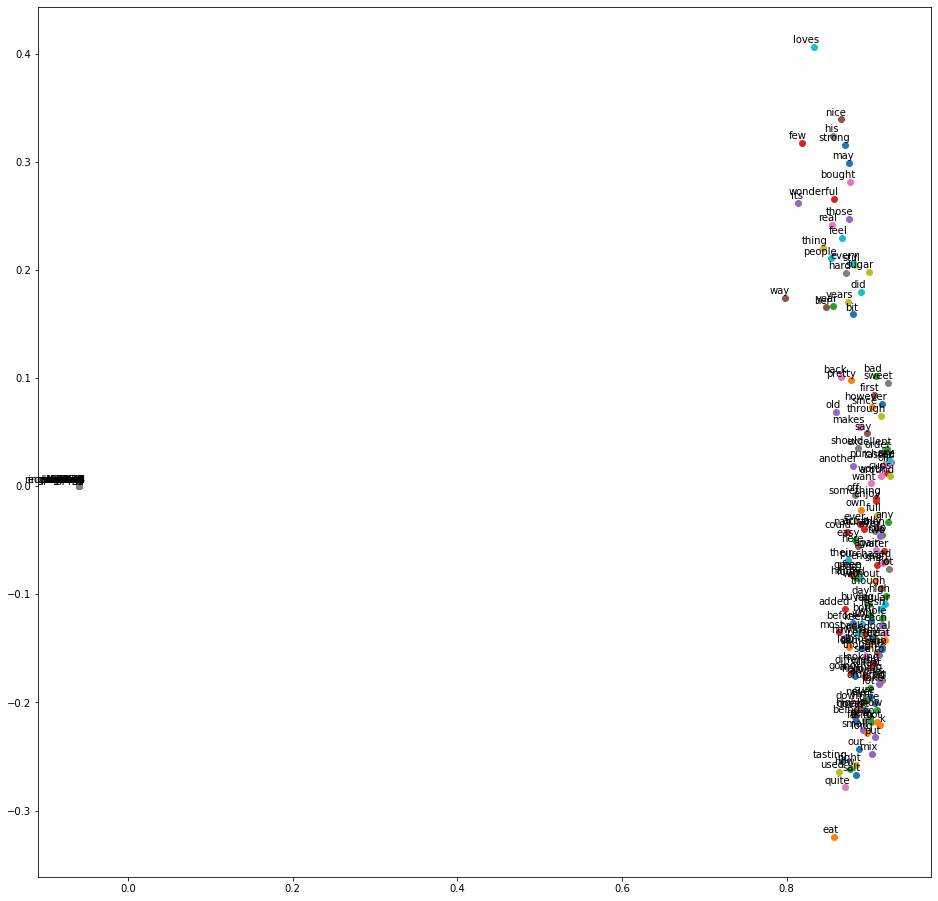

In [ ]:
plt.figure(figsize=(16, 16)) 
x = principalComponents3
for i in range(101,301):
  plt.scatter(x[i][0],x[i][1])
  plt.annotate(word_visul[i-1],
               xy=(x[i][0], x[i][1]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.savefig('img/singlegeco.png')

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

In [ ]:
pca = PCA(n_components=2)
principalComponents4 = pca.fit_transform(embedding_matrix_zuco)

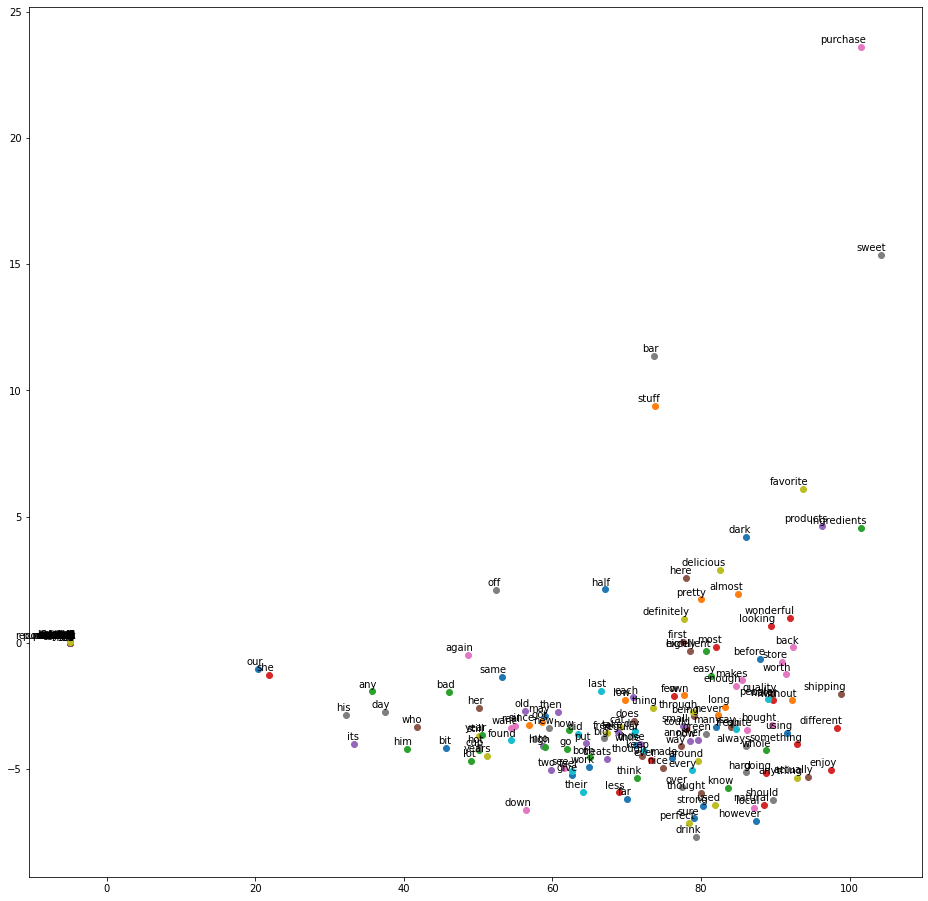

In [ ]:
plt.figure(figsize=(16, 16)) 
x = principalComponents4
for i in range(101,301):
  plt.scatter(x[i][0],x[i][1])
  plt.annotate(word_visul[i-1],
               xy=(x[i][0], x[i][1]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.savefig('img/visulzuco.png')

In [ ]:
pca = PCA(n_components=2)
principalComponents5 = pca.fit_transform(embedding_matrix_zuco[:,300:305])

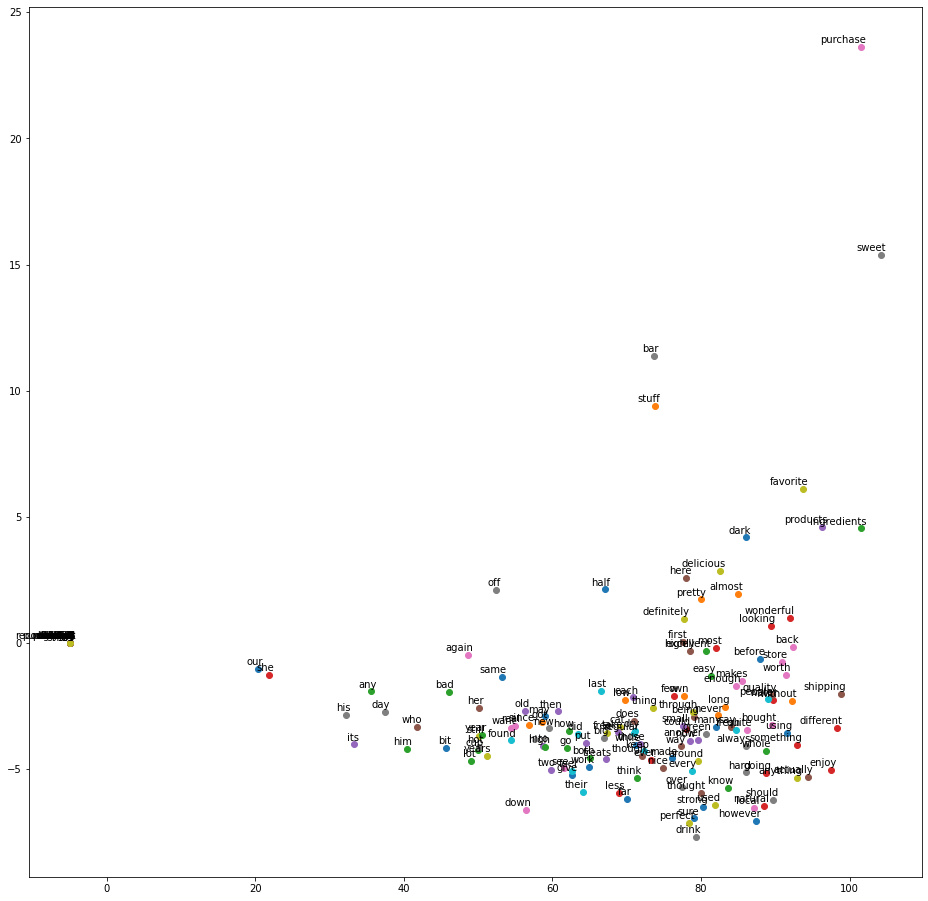

In [ ]:
plt.figure(figsize=(16, 16)) 
x = principalComponents5
for i in range(101,301):
  plt.scatter(x[i][0],x[i][1])
  plt.annotate(word_visul[i-1],
               xy=(x[i][0], x[i][1]),
               xytext=(5, 2),
               textcoords='offset points',
               ha='right',
               va='bottom')
plt.savefig('img/singlezuco.png')